# **Holcim  Data Science Assessment**

## **Credit Scoring Model: Predicting Credit Card Default**  

This notebook develops a **credit scoring model** using the **Taiwan credit card default dataset**. The goal is to predict the likelihood of default based on **payment history and financial behavior**, ensuring compliance with regulatory standards by avoiding demographic-based modeling.

### **Notebook Structure**  
1. **Data Preparation** – Load, clean, and preprocess data.  
2. **Exploratory Analysis** – Visualize key trends and feature distributions.  
3. **Model Training & Evaluation** – Train multiple models, optimise for recall, and compare performance.  
4. **Feature Importance** – Identify key predictors of default risk.  

This analysis prioritises **recall and cost-sensitive evaluation**, ensuring a model that minimizes undetected defaults while maintaining interpretability and fairness in credit risk assessment.


In [277]:
#### Import necessary libraries

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Statistical analysis
from scipy import stats

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            confusion_matrix, classification_report, roc_curve, 
                            roc_auc_score, precision_recall_curve, average_precision_score)
from sklearn.inspection import permutation_importance
import shap

# Feature selection
from sklearn.feature_selection import SelectFromModel, RFE

# For managing warnings
import warnings
warnings.filterwarnings('ignore')

In [279]:
# Set random seed for reproducibility
np.random.seed(42)

# For displaying all columns in pandas DataFrames
pd.set_option('display.max_columns', None)

### **1. Data Loading and Initial Exploration**



In [282]:
# Load the dataset
file_path = r"C:\Users\sofia\Downloads\holcim_assessment\default of credit card clients.xls"
df = pd.read_excel(file_path)

# Use first row as column names
df.columns = df.iloc[0]
df = df.drop(0).reset_index(drop=True)

# Display first few rows 
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [283]:
# Check the new dimensions of the dataset
print(df.shape)

# Check for missing values 
print("Total number of missing values in the dataset:")
df.isnull().sum().sum()

(30000, 25)
Total number of missing values in the dataset:


0

In [286]:
# Check basic statistics for the dataset
print("Dataset summary statistics:")
print(df.describe())

Dataset summary statistics:
0          ID  LIMIT_BAL    SEX  EDUCATION  MARRIAGE    AGE  PAY_0  PAY_2  \
count   30000      30000  30000      30000     30000  30000  30000  30000   
unique  30000         81      2          7         4     56     11     11   
top         1      50000      2          2         2     29      0      0   
freq        1       3365  18112      14030     15964   1605  14737  15730   

0       PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  \
count   30000  30000  30000  30000      30000      30000      30000   
unique     11     11     10     10      22723      22346      22026   
top         0      0      0      0          0          0          0   
freq    15764  16455  16947  16286       2008       2506       2870   

0       BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
count       30000      30000      30000     30000     30000     30000   
unique      21548      21010      20604      7943      7899      7518   
top        

#### **Display the column names and their descriptions**

In [289]:

column_descriptions = {
    'ID': 'ID of each client',
    'LIMIT_BAL': 'Amount of given credit (NT dollar)',
    'SEX': 'Gender (1 = male, 2 = female)',
    'EDUCATION': 'Education (1 = graduate school, 2 = university, 3 = high school, 4 = others)',
    'MARRIAGE': 'Marital status (1 = married, 2 = single, 3 = others)',
    'AGE': 'Age (years)',
    'PAY_0': 'Repayment status in September 2005 (-1 = pay duly, 1 = payment delay for one month, etc.)',
    'PAY_2': 'Repayment status in August 2005',
    'PAY_3': 'Repayment status in July 2005',
    'PAY_4': 'Repayment status in June 2005',
    'PAY_5': 'Repayment status in May 2005',
    'PAY_6': 'Repayment status in April 2005',
    'BILL_AMT1': 'Amount of bill statement in September 2005 (NT dollar)',
    'BILL_AMT2': 'Amount of bill statement in August 2005',
    'BILL_AMT3': 'Amount of bill statement in July 2005',
    'BILL_AMT4': 'Amount of bill statement in June 2005',
    'BILL_AMT5': 'Amount of bill statement in May 2005',
    'BILL_AMT6': 'Amount of bill statement in April 2005',
    'PAY_AMT1': 'Amount paid in September 2005 (NT dollar)',
    'PAY_AMT2': 'Amount paid in August 2005',
    'PAY_AMT3': 'Amount paid in July 2005',
    'PAY_AMT4': 'Amount paid in June 2005',
    'PAY_AMT5': 'Amount paid in May 2005',
    'PAY_AMT6': 'Amount paid in April 2005',
    'default.payment.next.month': 'Default payment (1 = yes, 0 = no)'
}

# Create a DataFrame of column descriptions
descriptions_df = pd.DataFrame({
    'Column Name': list(column_descriptions.keys()),
    'Description': list(column_descriptions.values())
})

print(descriptions_df)

# Rename the target variable for easier reference
df = df.rename(columns={'default payment next month': 'DEFAULT'})

                   Column Name  \
0                           ID   
1                    LIMIT_BAL   
2                          SEX   
3                    EDUCATION   
4                     MARRIAGE   
5                          AGE   
6                        PAY_0   
7                        PAY_2   
8                        PAY_3   
9                        PAY_4   
10                       PAY_5   
11                       PAY_6   
12                   BILL_AMT1   
13                   BILL_AMT2   
14                   BILL_AMT3   
15                   BILL_AMT4   
16                   BILL_AMT5   
17                   BILL_AMT6   
18                    PAY_AMT1   
19                    PAY_AMT2   
20                    PAY_AMT3   
21                    PAY_AMT4   
22                    PAY_AMT5   
23                    PAY_AMT6   
24  default.payment.next.month   

                                          Description  
0                                   ID of each client  
1  

### **Target Variable Analysis**

This plot will visualize the rate of default within the dataset

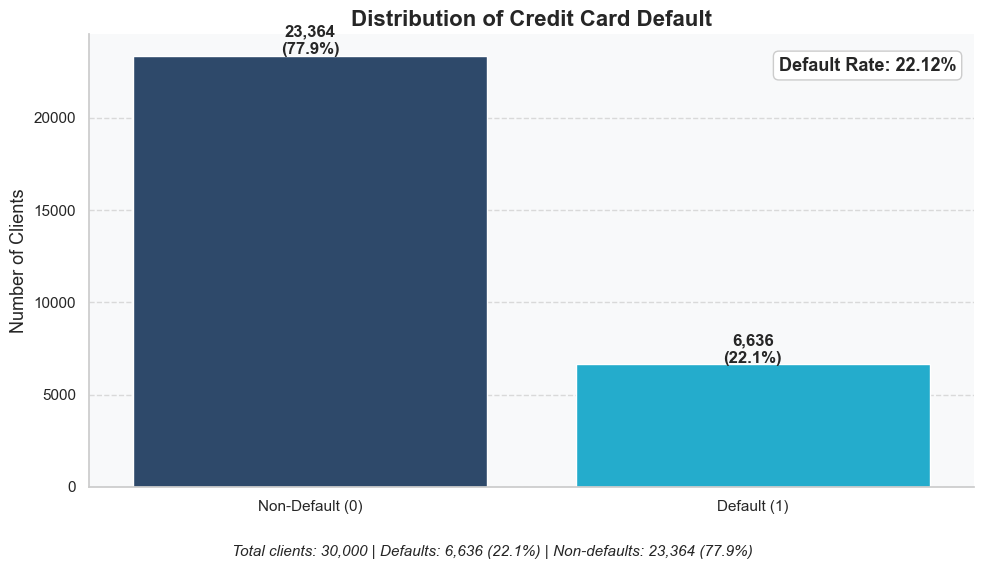

In [292]:
# Target distribution plot
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

# Calculate default rate and counts
default_rate = df['DEFAULT'].mean() * 100
total = len(df)
default_count = df['DEFAULT'].sum()
non_default_count = total - default_count

# Define colors and labels
colors = ['#244874', '#08bde8']  # Dark blue for non-default, light blue for default
x_labels = ['Non-Default (0)', 'Default (1)']

# Create the count plot
sns.countplot(x='DEFAULT', data=df, palette=colors, ax=ax)
ax.set_title('Distribution of Credit Card Default', fontsize=16, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('Number of Clients', fontsize=13)
ax.set_xticklabels(x_labels)

# Add count and percentage labels on bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 100,
            f'{int(height):,}\n({height/total:.1%})',
            ha="center", fontsize=12, fontweight='bold')

# Add default rate annotation
ax.text(0.98, 0.92, f'Default Rate: {default_rate:.2f}%',
        transform=ax.transAxes, fontsize=13, fontweight='bold',
        bbox=dict(facecolor='white', boxstyle='round', edgecolor='#cccccc'),
        ha='right')

# Clean styling
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_facecolor('#f8f9fa')

# Add caption
plt.figtext(0.5, 0.01, 
            f"Total clients: {total:,} | Defaults: {default_count:,} ({default_rate:.1f}%) | Non-defaults: {non_default_count:,} ({100-default_rate:.1f}%)",
            ha='center', fontsize=11, fontstyle='italic')

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot1.png")
plt.show()

## **Correlation matrix visualization**


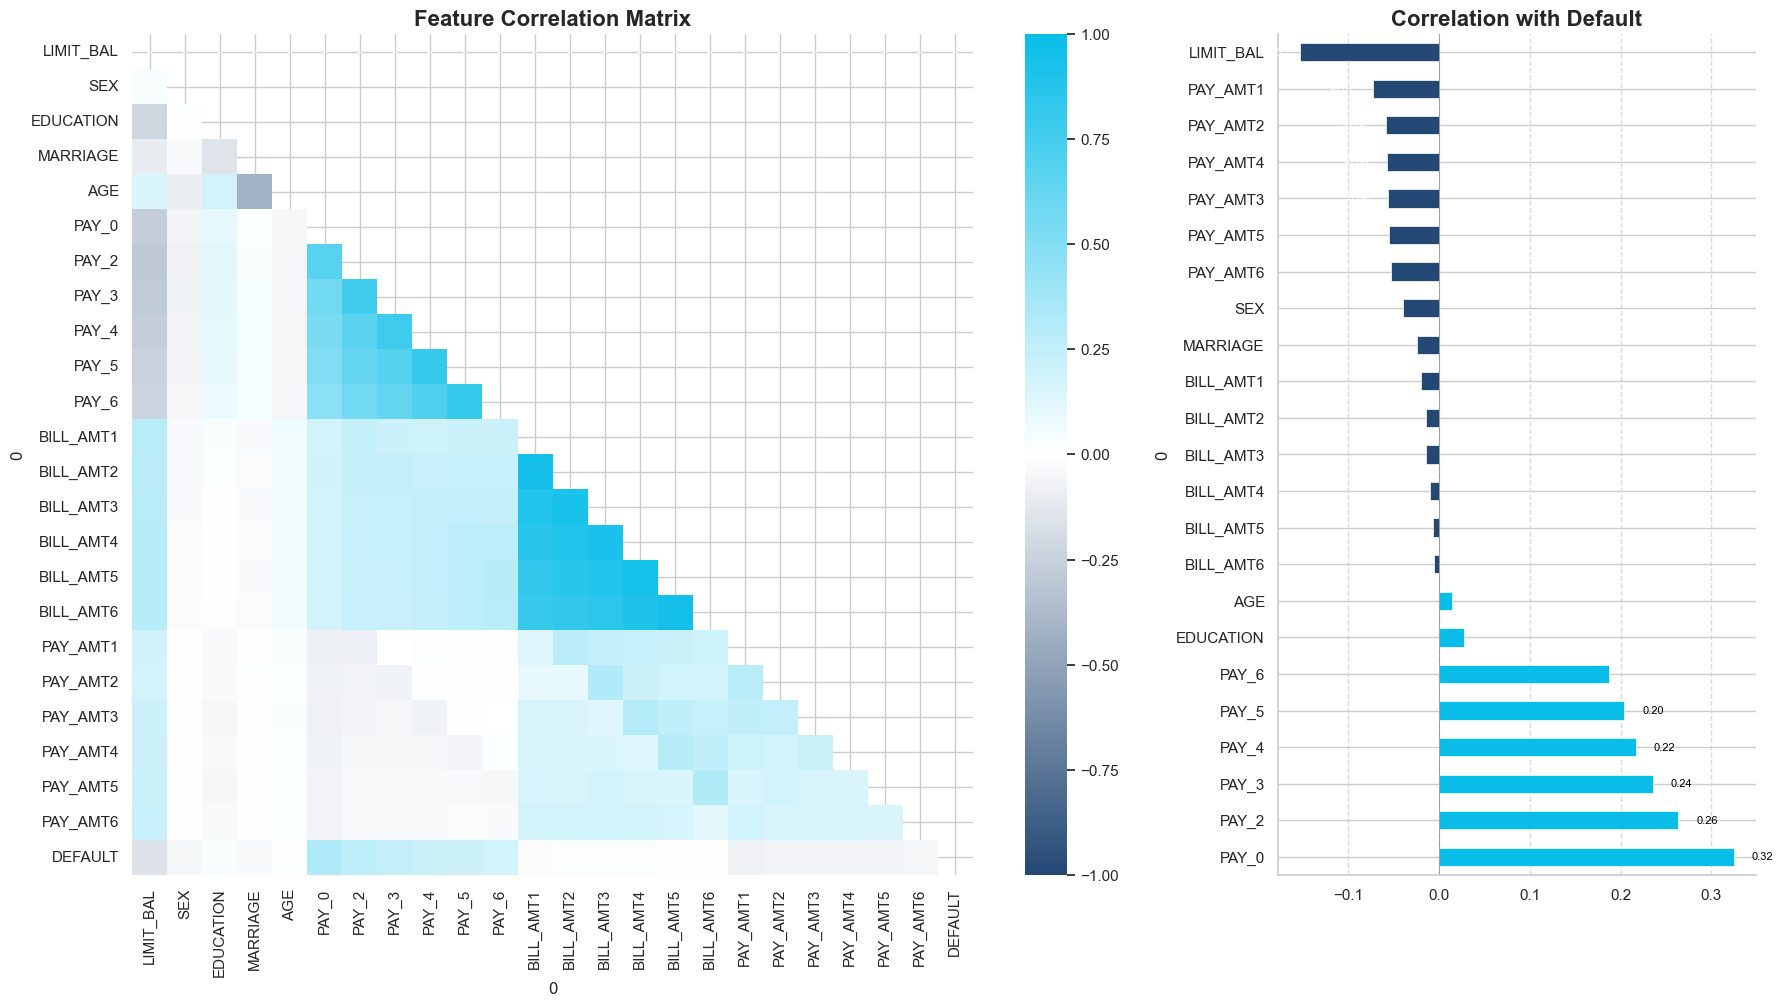

In [295]:
import matplotlib.colors as mcolors

# Create the correlation matrix
corr_matrix = df.drop('ID', axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a custom blue colourmap
colors = ['#244874', 'white', '#08bde8']  # Dark blue, white, light blue
cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', colors, N=256)

# Setup figure with two subplots
fig = plt.figure(figsize=(18, 10), facecolor='white')

# Plot 1: Main correlation heatmap
ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)
sns.heatmap(
    corr_matrix, 
    mask=mask, 
    cmap=cmap, 
    vmin=-1, vmax=1, center=0,
    square=True, 
    annot=True, 
    fmt=".2f", 
    annot_kws={"size": 7},
    ax=ax1
)
ax1.set_title('Feature Correlation Matrix', fontsize=16, fontweight='bold')

# Plot 2: Correlation with DEFAULT
ax2 = plt.subplot2grid((1, 3), (0, 2))
target_corr = corr_matrix['DEFAULT'].drop('DEFAULT').sort_values(ascending=False)

# Get colours based on correlation values
bar_colors = ['#08bde8' if x >= 0 else '#244874' for x in target_corr]

# Create the bar plot
target_corr.plot(
    kind='barh', 
    ax=ax2, 
    color=bar_colors,
    edgecolor='white',
    linewidth=0.5
)
ax2.set_title('Correlation with Default', fontsize=16, fontweight='bold')
ax2.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
ax2.grid(axis='x', linestyle='--', alpha=0.7)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Highlight top 5 positive and negative correlations
for i, v in enumerate(target_corr):
    if i < 5 or i > len(target_corr) - 6:  # Top 5 positive and negative
        ax2.text(
            v + (0.02 if v >= 0 else -0.02), 
            i, 
            f"{v:.2f}", 
            va='center',
            ha='left' if v >= 0 else 'right',
            fontsize=8,
            color='black' if v >= 0 else 'white'
        )

plt.tight_layout()
plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot2.png")
plt.show()


## **Demographic analysis plot**

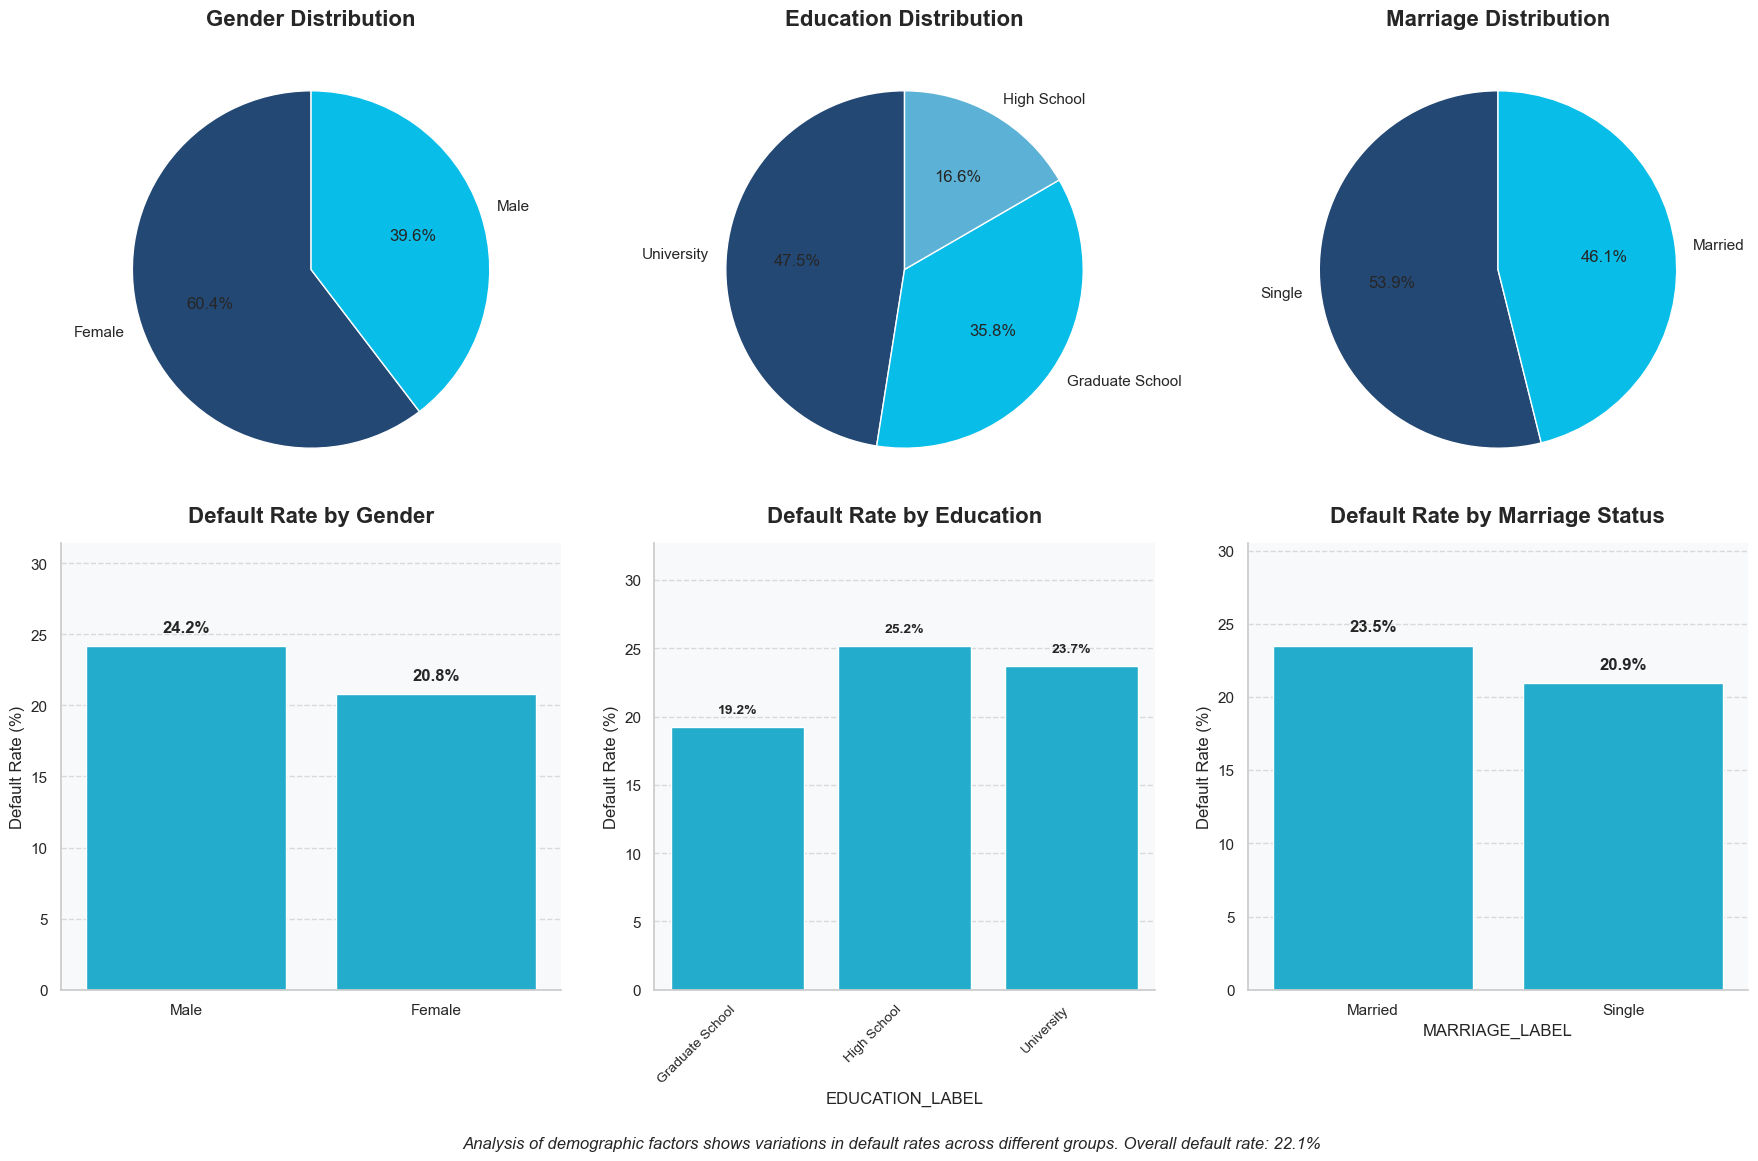

In [297]:
# Demographic analysis plot

# Setup the figure and colours
fig = plt.figure(figsize=(18, 12), facecolor='white')
pie_colors = ['#244874', '#08bde8']  # For pie charts (2 categories)
pie_colors_multi = ['#244874', '#08bde8', '#5cb2d6', '#0a6396', '#3e81a9']  # For pie charts (multiple categories)

default_palette = ['#08bde8'] * 10  # Light blue for all bars

# 1. Gender Distribution and Default Rate
# Distribution pie chart
plt.subplot(2, 3, 1)
gender_counts = df['SEX'].value_counts()
gender_labels = {1: 'Male', 2: 'Female'}
plt.pie(
    gender_counts, 
    labels=[gender_labels[i] for i in gender_counts.index], 
    autopct='%1.1f%%', 
    colors=pie_colors, 
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title('Gender Distribution', fontsize=16, fontweight='bold', pad=15)

# Default rate by gender
plt.subplot(2, 3, 4)
gender_default = df.groupby('SEX')['DEFAULT'].mean() * 100
gender_default.index = [gender_labels[i] for i in gender_default.index]
ax = sns.barplot(x=gender_default.index, y=gender_default.values, palette=default_palette)
plt.title('Default Rate by Gender', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.ylim(0, gender_default.max() * 1.3)  # Dynamic scaling with buffer space
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_facecolor('#f8f9fa')

# Add value labels
for i, v in enumerate(gender_default.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight='bold')

# 2. Education Distribution and Default Rate
# Remove 'Others' label
plt.subplot(2, 3, 2)
education_mapping = {1: 'Graduate School', 2: 'University', 3: 'High School'}
df['EDUCATION_LABEL'] = df['EDUCATION'].map(education_mapping).dropna()
education_counts = df['EDUCATION_LABEL'].value_counts()
plt.pie(
    education_counts, 
    labels=education_counts.index, 
    autopct='%1.1f%%', 
    colors=pie_colors_multi[:len(education_counts)], 
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title('Education Distribution', fontsize=16, fontweight='bold', pad=15)

# Default rate by education
plt.subplot(2, 3, 5)
education_default = df.groupby('EDUCATION_LABEL')['DEFAULT'].mean() * 100
ax = sns.barplot(x=education_default.index, y=education_default.values, palette=default_palette)
plt.title('Default Rate by Education', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, education_default.max() * 1.3)  # Dynamic scaling with buffer space
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_facecolor('#f8f9fa')

# Add value labels
for i, v in enumerate(education_default.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10, fontweight='bold')

# 3. Marriage Distribution and Default Rate
# Remove 'Others' label
plt.subplot(2, 3, 3)
marriage_mapping = {1: 'Married', 2: 'Single'}
df['MARRIAGE_LABEL'] = df['MARRIAGE'].map(marriage_mapping).dropna()
marriage_counts = df['MARRIAGE_LABEL'].value_counts()
plt.pie(
    marriage_counts, 
    labels=marriage_counts.index, 
    autopct='%1.1f%%', 
    colors=pie_colors_multi[:len(marriage_counts)], 
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title('Marriage Distribution', fontsize=16, fontweight='bold', pad=15)

# Default rate by marriage
plt.subplot(2, 3, 6)
marriage_default = df.groupby('MARRIAGE_LABEL')['DEFAULT'].mean() * 100
ax = sns.barplot(x=marriage_default.index, y=marriage_default.values, palette=default_palette)
plt.title('Default Rate by Marriage Status', fontsize=16, fontweight='bold', pad=15)
plt.ylabel('Default Rate (%)', fontsize=12)
plt.ylim(0, marriage_default.max() * 1.3)  # Dynamic scaling with buffer space
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.set_facecolor('#f8f9fa')

# Add value labels
for i, v in enumerate(marriage_default.values):
    ax.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=12, fontweight='bold')

# Add a summary caption at the bottom
plt.figtext(
    0.5, 0.01, 
    "Analysis of demographic factors shows variations in default rates across different groups. " +
    f"Overall default rate: {df['DEFAULT'].mean()*100:.1f}%",
    ha='center', 
    fontsize=12, 
    fontstyle='italic'
)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot3.png")
plt.show()

## **Payment history analysis**

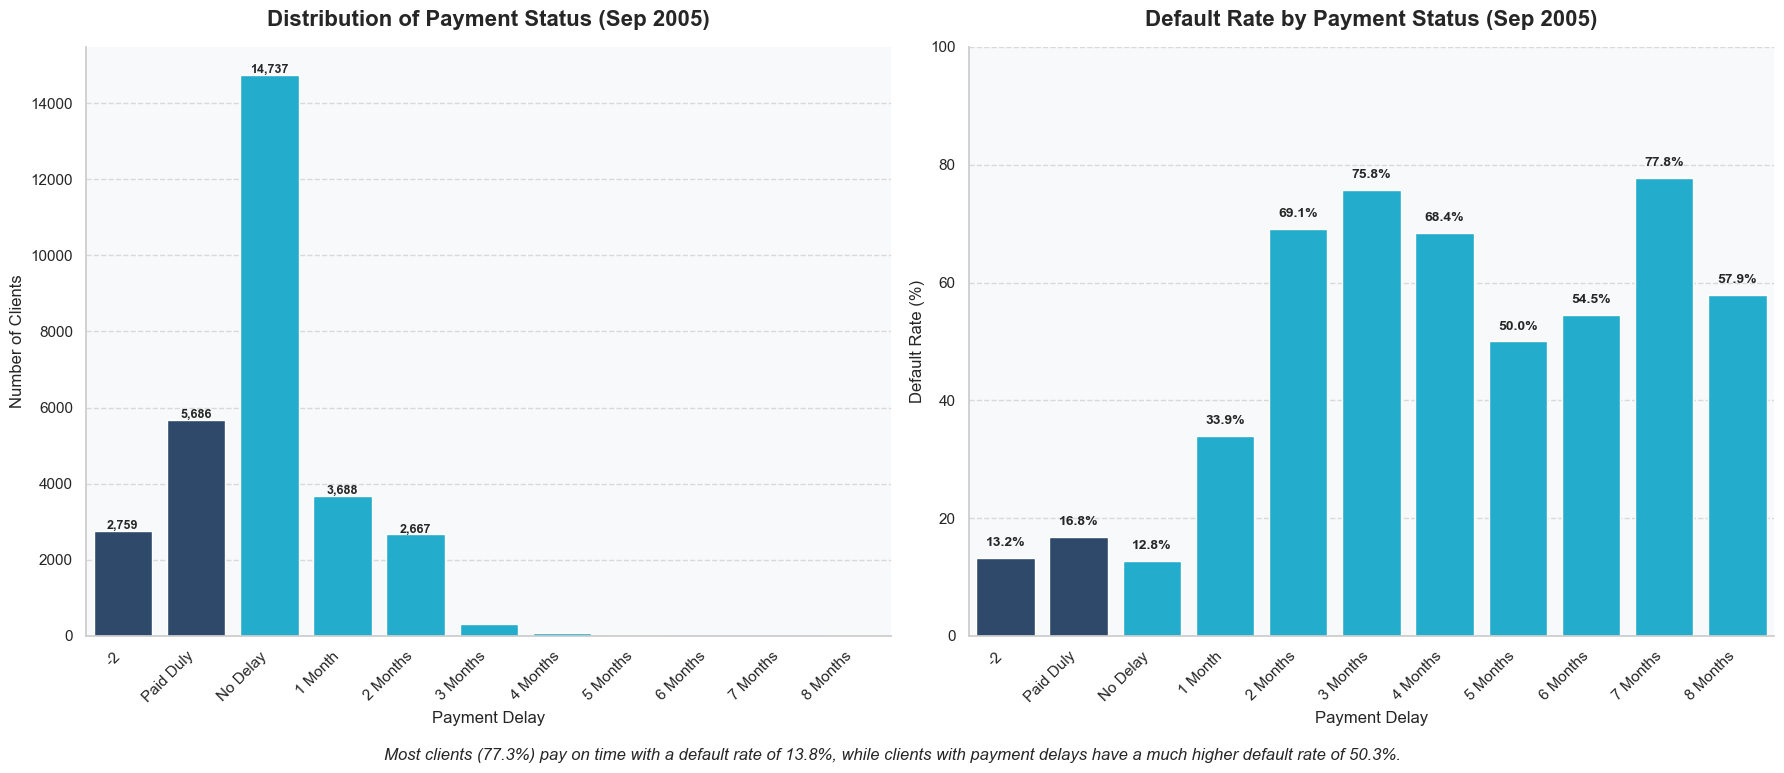

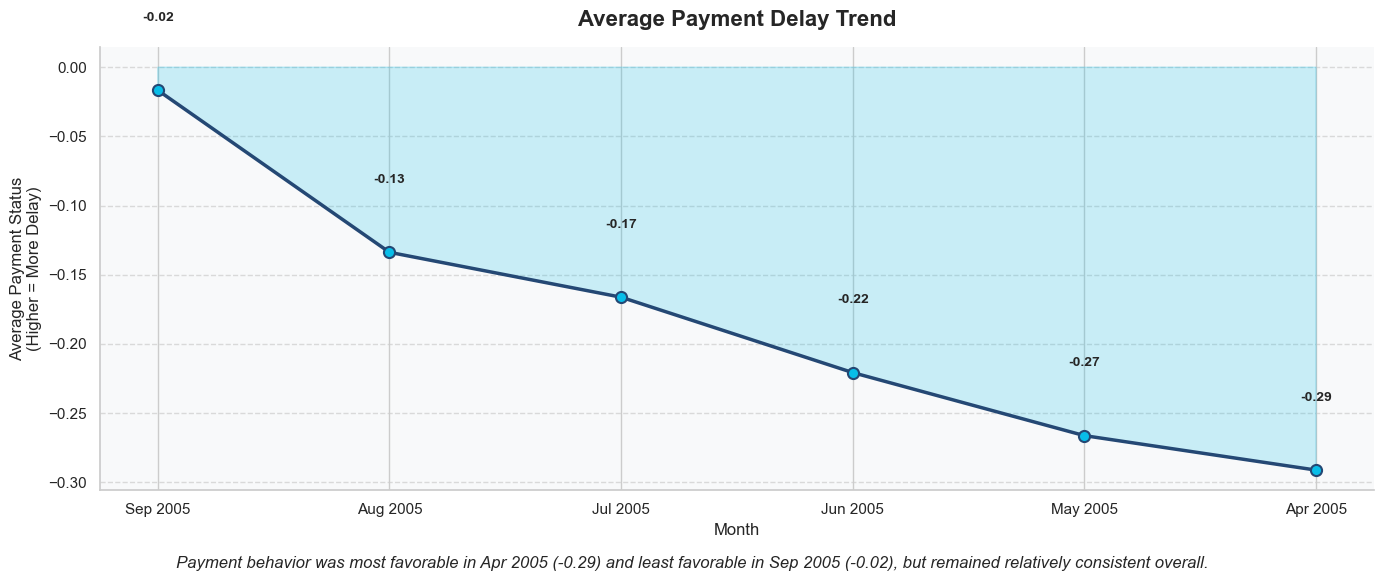

In [309]:
# Define consistent color scheme
primary_dark_blue = '#244874'
primary_light_blue = '#08bde8'
light_background = '#f8f9fa'

# Get payment history columns
payment_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
payment_labels = ['Sep 2005', 'Aug 2005', 'Jul 2005', 'Jun 2005', 'May 2005', 'Apr 2005']

# Create better descriptions for payment status
payment_status_desc = {
    -1: 'Paid Duly',
    0: 'No Delay',
    1: '1 Month',
    2: '2 Months',
    3: '3 Months',
    4: '4 Months',
    5: '5 Months',
    6: '6 Months',
    7: '7 Months',
    8: '8 Months',
    9: '9+ Months'
}

# Function to generate colours for payment status
def get_payment_colors(values):
    return [primary_dark_blue if x < 0 else primary_light_blue for x in values]

# Function to apply consistent styling to axes
def style_axis(ax, title, xlabel=None, ylabel=None, ylim=None):
    ax.set_title(title, fontsize=16, fontweight='bold', pad=15)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12)
    if ylim:
        ax.set_ylim(ylim)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_facecolor(light_background)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax

# =============== FIGURE 1: Payment Status Distribution and Default Rate ===============
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8), facecolor='white')

# Plot 1: Distribution of payment status for Sep 2005
payment_status_counts = df['PAY_0'].value_counts().sort_index()
sns.barplot(x=payment_status_counts.index, y=payment_status_counts.values, 
            palette=get_payment_colors(payment_status_counts.index), ax=ax1)

# Style the first plot
style_axis(ax1, 'Distribution of Payment Status (Sep 2005)', 
          'Payment Delay', 'Number of Clients')

# Add value labels to significant bars
for i, v in enumerate(payment_status_counts.values):
    if v > 500:  # Only show labels for bars with significant values
        ax1.text(i, v + 50, f"{v:,}", ha='center', fontsize=9, fontweight='bold')

# Improve x-tick labels
ax1.set_xticklabels([payment_status_desc.get(x, str(x)) for x in payment_status_counts.index], 
                   rotation=45, ha='right')

# Plot 2: Default rate by payment status
payment_default = df.groupby('PAY_0')['DEFAULT'].mean() * 100
sns.barplot(x=payment_default.index, y=payment_default.values, 
            palette=get_payment_colors(payment_default.index), ax=ax2)

# Style the second plot
style_axis(ax2, 'Default Rate by Payment Status (Sep 2005)', 
          'Payment Delay', 'Default Rate (%)', (0, 100))

# Add value labels to all bars in the default rate plot
for i, v in enumerate(payment_default.values):
    ax2.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=10, fontweight='bold')

# Improve x-tick labels
ax2.set_xticklabels([payment_status_desc.get(x, str(x)) for x in payment_default.index], 
                   rotation=45, ha='right')

# Add a summary annotation with data-driven insights
on_time_pct = len(df[df['PAY_0'] <= 0]) / len(df) * 100
delayed_default_rate = df[df['PAY_0'] > 0]['DEFAULT'].mean() * 100
on_time_default_rate = df[df['PAY_0'] <= 0]['DEFAULT'].mean() * 100

fig.text(0.5, 0.01, 
    f"Most clients ({on_time_pct:.1f}%) pay on time with a default rate of {on_time_default_rate:.1f}%, while "
    f"clients with payment delays have a much higher default rate of {delayed_default_rate:.1f}%.",
    ha='center', fontsize=12, fontstyle='italic')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot11.png")

plt.show()

# =============== FIGURE 2: Payment Status Trend Across Months ===============
plt.figure(figsize=(14, 6), facecolor='white')
ax = plt.gca()

# Calculate mean payment values and ensure they're plain numeric values
payment_means = df[payment_cols].mean().values
x_indices = np.arange(len(payment_labels))  # Use numeric indices for x

# Draw the main line plot
plt.plot(x_indices, payment_means, marker='o', color=primary_dark_blue, 
         linewidth=2.5, markersize=8, markerfacecolor=primary_light_blue, 
         markeredgecolor=primary_dark_blue, markeredgewidth=1.5)

# Use polygon fill to avoid fill_between error
x_poly = np.concatenate([x_indices, [x_indices[-1], x_indices[0]]])
y_poly = np.concatenate([payment_means, [0, 0]])
plt.fill(x_poly, y_poly, color=primary_light_blue, alpha=0.2)

# Add data point labels
for i, y in enumerate(payment_means):
    plt.text(i, y + 0.05, f"{y:.2f}", ha='center', fontsize=10, fontweight='bold')

# Style the plot
style_axis(ax, 'Average Payment Delay Trend', 'Month', 'Average Payment Status\n(Higher = More Delay)')

# Set x-ticks to show month labels
plt.xticks(x_indices, payment_labels)

# Add data-driven annotation
min_idx = np.argmin(payment_means)
max_idx = np.argmax(payment_means)
min_month = payment_labels[min_idx]
max_month = payment_labels[max_idx]

plt.figtext(0.5, 0.01, 
    f"Payment behavior was most favorable in {min_month} ({payment_means[min_idx]:.2f}) and "
    f"least favorable in {max_month} ({payment_means[max_idx]:.2f}), but remained relatively consistent overall.",
    ha='center', fontsize=12, fontstyle='italic')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot4.png")
plt.show()

# Data Preprocessing for Credit Scoring Model

In this section, I prepared the data for modelling by properly handling categorical variables and creating relevant financial behavior features. This preprocessing stage is crucial for credit scoring models to ensure proper treatment of different variable types and to extract meaningful information from the raw data.

## Variable Categorization
First, I categorized the variables into three types based on their semantic meaning:
- **Categorical variables**: SEX, EDUCATION, MARRIAGE - these are nominal categories with no inherent order
- **Ordinal variables**: PAY_0 through PAY_6 - these have an inherent order (months of payment delay)
- **Continuous variables**: LIMIT_BAL, AGE, BILL_AMT1-6, PAY_AMT1-6 - these are numerical quantities

## Data Cleaning
I addressed several data quality issues:
- Recoded unusual values in EDUCATION (values 0, 5, 6) to category 4 "Others"
- Fixed MARRIAGE coding by changing value 0 to category 3 "Others"
- Standardized PAY_* variables by converting -2 to -1 (both indicate paying duly)

## Feature Engineering
I created several domain-specific features to better capture credit risk patterns:

**Payment Behavior Indicators:**
- `EVER_DELAYED`: Binary flag indicating if a person ever delayed payment
- `MAX_DELAY`: Maximum number of months payment was delayed
- `RECENT_DELAY`: Weighted sum of delays (with recent delays weighted more heavily)

**Financial Utilization Metrics:**
- `UTIL_RATIO_*`: Utilization ratios for each month (bill amount / credit limit)
- `PAYMENT_RATIO_*`: Payment ratios for each month (amount paid / bill amount)
- `AVG_UTIL_RATIO`: Average utilization ratio across all months
- `AVG_PAYMENT_RATIO`: Average payment ratio across all months

These derived features help capture important credit risk factors like utilization patterns and payment consistency that are known predictors of default.

## Encoding Strategy
I implemented a two-pronged approach for feature encoding:
- Applied one-hot encoding to categorical variables (with drop='first' to avoid multicollinearity)
- Standardized numerical features using StandardScaler
- Preserved ordinal variables in their numerical form since they already have meaningful representation

## Implementation
The preprocessing was implemented as a scikit-learn pipeline using ColumnTransformer, ensuring:
- Consistent preprocessing between training and test data
- Proper handling of different variable types
- Easy integration with any machine learning model
- Reproducible data transformation process

The final preprocessed dataset includes 21 original features plus 17 engineered features, providing a rich set of predictors for the credit default prediction models.


==== Data Preprocessing for Credit Scoring Model ====
Categorical variables: ['SEX', 'EDUCATION', 'MARRIAGE']
Ordinal variables: ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Continuous variables: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

Cleaning EDUCATION variable:
EDUCATION value counts before cleaning:
EDUCATION
0       14
1    10585
2    14030
3     4917
4      123
5      280
6       51
Name: count, dtype: int64
EDUCATION value counts after cleaning:
EDUCATION
1    10585
2    14030
3     4917
4      468
Name: count, dtype: int64

Cleaning MARRIAGE variable:
MARRIAGE value counts before cleaning:
MARRIAGE
0       54
1    13659
2    15964
3      323
Name: count, dtype: int64
MARRIAGE value counts after cleaning:
MARRIAGE
1    13659
2    15964
3      377
Name: count, dtype: int64

Cleaning PAY_0 variable:
PAY_0 value counts before cleaning:
PAY_0

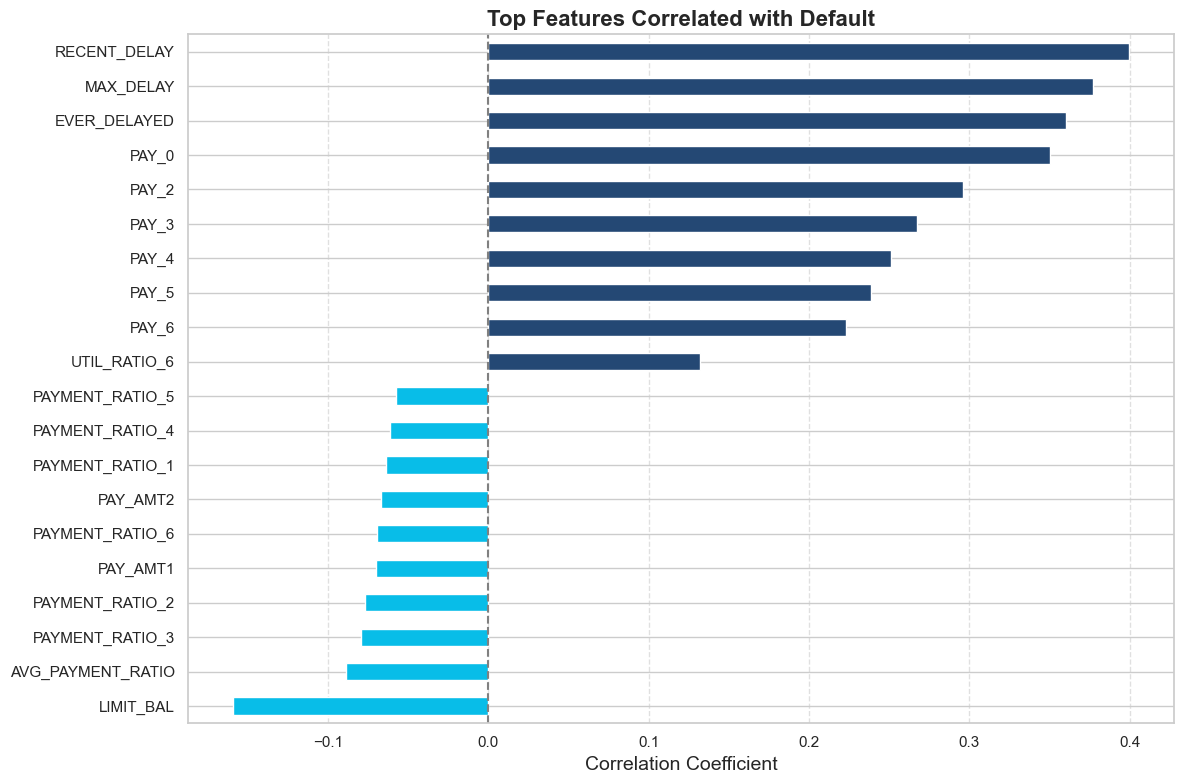


==== Data Preprocessing Complete ====
The data is now ready for modeling with the following components:
- Training set: 21000 samples with 40 features
- Transformed training set: 21000 samples with 43 features
- Testing set: 9000 samples with 40 features
- Preprocessing pipeline ready for integration with models


In [302]:
print("\n==== Data Preprocessing for Credit Scoring Model ====")

# Remove label columns that would cause problems with numeric processing
df_processed = df.drop(['EDUCATION_LABEL', 'MARRIAGE_LABEL'], axis=1)

# 2.1 Variable Categorisation
# Categorize variables based on their semantic meaning
categorical_variables = ['SEX', 'EDUCATION', 'MARRIAGE']
ordinal_variables = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
continuous_variables = ['LIMIT_BAL', 'AGE', 
                      'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                      'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

print(f"Categorical variables: {categorical_variables}")
print(f"Ordinal variables: {ordinal_variables}")
print(f"Continuous variables: {continuous_variables}")

# 2.2 Data Cleaning
# Handle unusual values in categorical and ordinal variables

# EDUCATION: Recode unusual values (0, 5, 6) to category 4 "Others"
print("\nCleaning EDUCATION variable:")
print(f"EDUCATION value counts before cleaning:\n{df_processed['EDUCATION'].value_counts().sort_index()}")
df_processed['EDUCATION'] = df_processed['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
print(f"EDUCATION value counts after cleaning:\n{df_processed['EDUCATION'].value_counts().sort_index()}")

# MARRIAGE: Change value 0 to category 3 "Others"
print("\nCleaning MARRIAGE variable:")
print(f"MARRIAGE value counts before cleaning:\n{df_processed['MARRIAGE'].value_counts().sort_index()}")
df_processed['MARRIAGE'] = df_processed['MARRIAGE'].replace({0: 3})
print(f"MARRIAGE value counts after cleaning:\n{df_processed['MARRIAGE'].value_counts().sort_index()}")

# PAY_* variables: Standardize -2 to -1 (both indicate paying duly)
for col in ordinal_variables:
    print(f"\nCleaning {col} variable:")
    print(f"{col} value counts before cleaning:\n{df_processed[col].value_counts().sort_index()}")
    df_processed[col] = df_processed[col].replace({-2: -1})
    print(f"{col} value counts after cleaning:\n{df_processed[col].value_counts().sort_index()}")

# 2.3 Feature Engineering
print("\n==== Creating Engineered Features ====")

# 2.3.1 Payment Behavior Indicators

# EVER_DELAYED: Binary flag if a person ever delayed payment
df_processed['EVER_DELAYED'] = (df_processed[ordinal_variables] > 0).any(axis=1).astype(int)
print(f"EVER_DELAYED counts:\n{df_processed['EVER_DELAYED'].value_counts()}")

# MAX_DELAY: Maximum number of months payment was delayed
df_processed['MAX_DELAY'] = df_processed[ordinal_variables].max(axis=1)
df_processed['MAX_DELAY'] = df_processed['MAX_DELAY'].clip(lower=0)  # Set negative values to 0
print(f"MAX_DELAY distribution:\n{df_processed['MAX_DELAY'].value_counts().sort_index()}")

# RECENT_DELAY: Weighted sum of delays (more recent = higher weight)
weights = [6, 5, 4, 3, 2, 1]  # Most recent month has highest weight
delay_cols = df_processed[ordinal_variables].clip(lower=0)  # Only consider actual delays (values > 0)
df_processed['RECENT_DELAY'] = sum(delay_cols[col] * w for col, w in zip(ordinal_variables, weights))
print(f"RECENT_DELAY statistics:\nMin: {df_processed['RECENT_DELAY'].min()}, Max: {df_processed['RECENT_DELAY'].max()}, Mean: {df_processed['RECENT_DELAY'].mean():.2f}")

# 2.3.2 Financial Utilization Metrics

# UTIL_RATIO_*: Utilization ratios (bill amount / credit limit)
for i in range(1, 7):
    # Safe calculation with lambda function
    df_processed[f'UTIL_RATIO_{i}'] = df_processed.apply(
        lambda x: 0 if x['LIMIT_BAL'] <= 0 else min(1, max(0, x[f'BILL_AMT{i}'] / x['LIMIT_BAL'])), 
        axis=1
    )
    print(f"UTIL_RATIO_{i} statistics: Mean: {df_processed[f'UTIL_RATIO_{i}'].mean():.4f}")

# PAYMENT_RATIO_*: Payment ratios (amount paid / bill amount)
for i in range(1, 7):
    # Safe calculation with lambda function
    df_processed[f'PAYMENT_RATIO_{i}'] = df_processed.apply(
        lambda x: 1.0 if x[f'BILL_AMT{i}'] <= 0 else min(1, max(0, x[f'PAY_AMT{i}'] / x[f'BILL_AMT{i}'])),
        axis=1
    )
    print(f"PAYMENT_RATIO_{i} statistics: Mean: {df_processed[f'PAYMENT_RATIO_{i}'].mean():.4f}")

# AVG_UTIL_RATIO: Average utilization ratio across all months
util_ratio_cols = [f'UTIL_RATIO_{i}' for i in range(1, 7)]
df_processed['AVG_UTIL_RATIO'] = df_processed[util_ratio_cols].mean(axis=1)
print(f"AVG_UTIL_RATIO statistics: Mean: {df_processed['AVG_UTIL_RATIO'].mean():.4f}")

# AVG_PAYMENT_RATIO: Average payment ratio across all months
payment_ratio_cols = [f'PAYMENT_RATIO_{i}' for i in range(1, 7)]
df_processed['AVG_PAYMENT_RATIO'] = df_processed[payment_ratio_cols].mean(axis=1)
print(f"AVG_PAYMENT_RATIO statistics: Mean: {df_processed['AVG_PAYMENT_RATIO'].mean():.4f}")

# 2.4 Data Splitting and Preparation for Modeling
# Prepare data for modeling by creating X and y datasets

# Drop ID column before creating train/test sets
df_processed = df_processed.drop('ID', axis=1)

# Create X (features) and y (target)
X = df_processed.drop('DEFAULT', axis=1)
y = df_processed['DEFAULT']

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Default rate in training set: {y_train.mean()*100:.2f}%")
print(f"Default rate in testing set: {y_test.mean()*100:.2f}%")

# 2.5 Feature Encoding and Scaling
# Define which columns should be processed in which way for the model
categorical_features = categorical_variables
numerical_features = continuous_variables + util_ratio_cols + payment_ratio_cols + ['AVG_UTIL_RATIO', 'AVG_PAYMENT_RATIO']
# Include engineered ordinal features
ordinal_features = ordinal_variables + ['EVER_DELAYED', 'MAX_DELAY', 'RECENT_DELAY'] 

print(f"\nFeature sets for preprocessing:")
print(f"Categorical features (one-hot encoded): {len(categorical_features)} features")
print(f"Numerical features (standardized): {len(numerical_features)} features")
print(f"Ordinal features (kept as-is): {len(ordinal_features)} features")

# Create preprocessing transformers for each type of feature
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough'  # This will keep the ordinal features as-is
)

# Create a pipeline that includes preprocessing and will be ready for a model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit the preprocessor to the training data
X_train_transformed = pipeline.fit_transform(X_train)

# Show a sample of the transformed data
print(f"\nTransformed training data shape: {X_train_transformed.shape}")

# Calculate the number of features after one-hot encoding
n_cat_features = sum(len(X_train[col].unique()) - 1 for col in categorical_features)  # -1 for drop='first'
n_num_features = len(numerical_features)
n_ord_features = len(ordinal_features)
total_features = n_cat_features + n_num_features + n_ord_features

print(f"\nFeature counts after transformation:")
print(f"One-hot encoded categorical features: {n_cat_features}")
print(f"Standardized numerical features: {n_num_features}")
print(f"Unchanged ordinal features: {n_ord_features}")
print(f"Total features: {total_features}")

# 2.6 Visualize important relationships (optional but informative)
# Let's look at the correlation of features with the target

# Create a function to generate feature names after one-hot encoding
def get_feature_names(pipeline, categorical_features, numerical_features, ordinal_features):
    """Get feature names after transformation."""
    cat_encoder = pipeline.named_steps['preprocessor'].transformers_[0][1]
    cat_features_encoded = cat_encoder.get_feature_names_out(categorical_features)
    
    # Combine all feature names in the correct order
    feature_names = list(cat_features_encoded) + list(numerical_features) + list(ordinal_features)
    return feature_names

# Get transformed feature names
try:
    transformed_feature_names = get_feature_names(pipeline, categorical_features, numerical_features, ordinal_features)
    
    # Create a DataFrame with transformed features
    X_train_transformed_df = pd.DataFrame(
        X_train_transformed,
        columns=transformed_feature_names
    )
    
    # Add target variable for correlation analysis
    X_train_transformed_df['DEFAULT'] = y_train.values
    
    # Calculate correlations with target variable
    correlations = X_train_transformed_df.corr()['DEFAULT'].sort_values(ascending=False)
    
    # Display top correlations
    print("\nTop 10 features positively correlated with DEFAULT:")
    print(correlations.head(11).drop('DEFAULT'))
    
    print("\nTop 10 features negatively correlated with DEFAULT:")
    print(correlations.tail(10))
    
    # Create correlation visualization (optional)
    plt.figure(figsize=(12, 8))
    top_features = list(correlations.head(11).drop('DEFAULT').index) + list(correlations.tail(10).index)
    correlation_subset = X_train_transformed_df[top_features + ['DEFAULT']].corr()['DEFAULT'][top_features]
    
    # Create bar chart
    colors = ['#08bde8' if c >= 0 else '#244874' for c in correlation_subset]
    ax = correlation_subset.sort_values().plot(kind='barh', color=colors, figsize=(12, 8))
    ax.set_title('Top Features Correlated with Default', fontsize=16, fontweight='bold')
    ax.set_xlabel('Correlation Coefficient', fontsize=14)
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot5.png")
    plt.show()    
except Exception as e:
    print(f"Could not generate correlation visualization: {e}")
    print("Continuing with preprocessing...")

print("\n==== Data Preprocessing Complete ====")
print("The data is now ready for modeling with the following components:")
print(f"- Training set: {X_train.shape[0]} samples with {X_train.shape[1]} features")
print(f"- Transformed training set: {X_train_transformed.shape[0]} samples with {X_train_transformed.shape[1]} features")
print(f"- Testing set: {X_test.shape[0]} samples with {X_test.shape[1]} features")
print("- Preprocessing pipeline ready for integration with models")

# **Baseline models**
### In this section I will implement a Logistic Regression benchmark model:

Target variable types:
y_train type: <class 'pandas.core.series.Series'>, dtype: int32
y_test type: <class 'pandas.core.series.Series'>, dtype: int32
y_train unique values: [0 1]
y_test unique values: [0 1]

==== Logistic Regression Benchmark Model ====
Prediction type: <class 'numpy.ndarray'>, dtype: int32
Unique predicted values: [0 1]

----- Logistic Regression Performance -----
Recall: 0.6062 (Primary metric)
Precision: 0.4426
F1 Score: 0.5117
F2 Score: 0.5645
ROC AUC: 0.7638

Confusion Matrix:
True Negatives: 5489 | False Positives: 1520
False Negatives: 784 | True Positives: 1207
Weighted Cost: 5440 (FN weighted 5x more than FP)


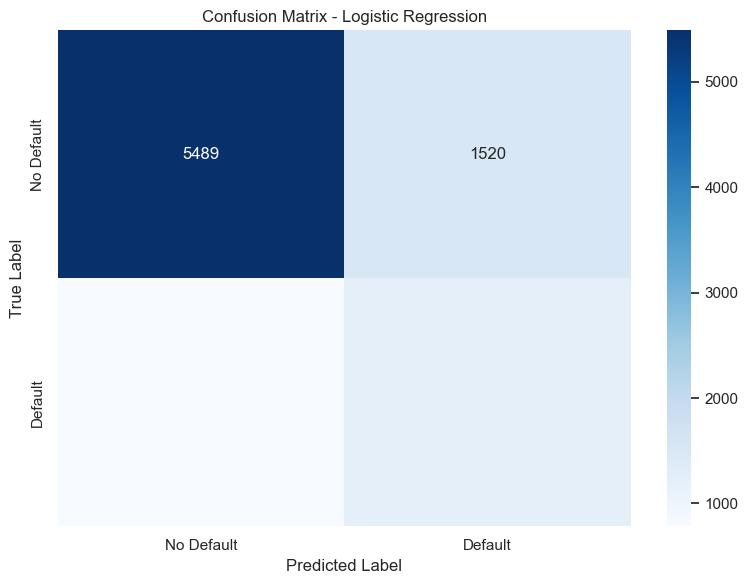

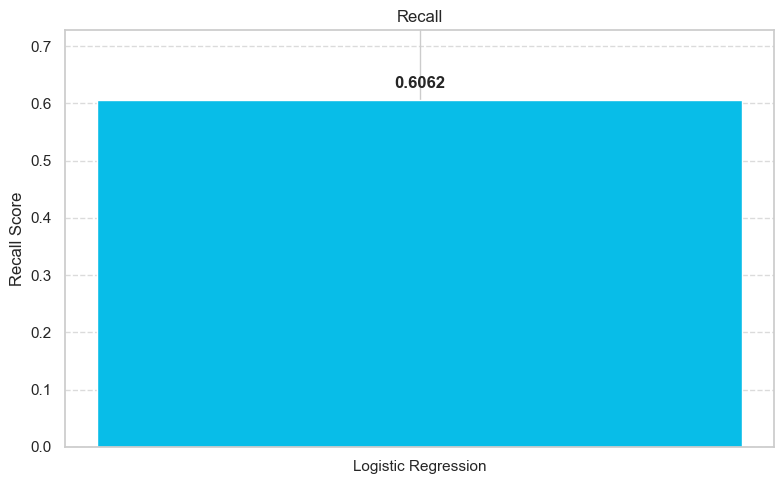

In [311]:
# First, ensure target variables are properly converted to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print(f"Target variable types:")
print(f"y_train type: {type(y_train)}, dtype: {y_train.dtype}")
print(f"y_test type: {type(y_test)}, dtype: {y_test.dtype}")
print(f"y_train unique values: {np.unique(y_train)}")
print(f"y_test unique values: {np.unique(y_test)}")

# 3.1 Evaluation Function
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model with focus on recall."""
    # Generate predictions
    y_pred = model.predict(X_test)
    
    # Convert predictions to integer type
    y_pred = y_pred.astype(int)
    
    # Verify data types
    print(f"Prediction type: {type(y_pred)}, dtype: {y_pred.dtype}")
    print(f"Unique predicted values: {np.unique(y_pred)}")
    
    # Generate probability predictions if available
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = None
    
    # Calculate metrics
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)  # F2 score prioritizes recall
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate cost (assuming FN costs 5x more than FP)
    fn_cost_weight = 5
    cost = fp + (fn * fn_cost_weight)
    
    # Print results
    print(f"\n----- {model_name} Performance -----")
    print(f"Recall: {recall:.4f} (Primary metric)")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    if roc_auc is not None:
        print(f"ROC AUC: {roc_auc:.4f}")
    
    print(f"\nConfusion Matrix:")
    print(f"True Negatives: {tn} | False Positives: {fp}")
    print(f"False Negatives: {fn} | True Positives: {tp}")
    print(f"Weighted Cost: {cost} (FN weighted 5x more than FP)")
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot10.png")

    plt.show()
    
    # Return metrics for comparison
    return {
        'model': model_name,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'f2': f2,
        'roc_auc': roc_auc,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'cost': cost
    }

# 3.2 Logistic Regression Benchmark
print("\n==== Logistic Regression Benchmark Model ====")

# Create a pipeline with preprocessing and logistic regression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Train logistic regression model
logreg_pipeline.fit(X_train, y_train)

# Evaluate logistic regression model
logreg_metrics = evaluate_model(logreg_pipeline, X_test, y_test, "Logistic Regression")

# Display recall comparison
plt.figure(figsize=(8, 5))
plt.bar(['Logistic Regression'], [logreg_metrics['recall']], color=['#08bde8'])
plt.title('Recall')
plt.ylabel('Recall Score')
plt.ylim(0, max(logreg_metrics['recall'] * 1.2, 0.5))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
plt.text(0, logreg_metrics['recall'] + 0.02, f"{logreg_metrics['recall']:.4f}", 
         ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


# **Gradient Boosted Classifier**
### Implementation of a Gradient Boosting Classifier for credit default prediction, in which we will compare to the benchmark models 



==== Gradient Boosting Model ====
Prediction type: <class 'numpy.ndarray'>, dtype: int32
Unique predicted values: [0 1]

----- Gradient Boosting (Default) Performance -----
Recall: 0.3651 (Primary metric)
Precision: 0.6676
F1 Score: 0.4721
F2 Score: 0.4015
ROC AUC: 0.7835

Confusion Matrix:
True Negatives: 6647 | False Positives: 362
False Negatives: 1264 | True Positives: 727
Weighted Cost: 6682 (FN weighted 5x more than FP)


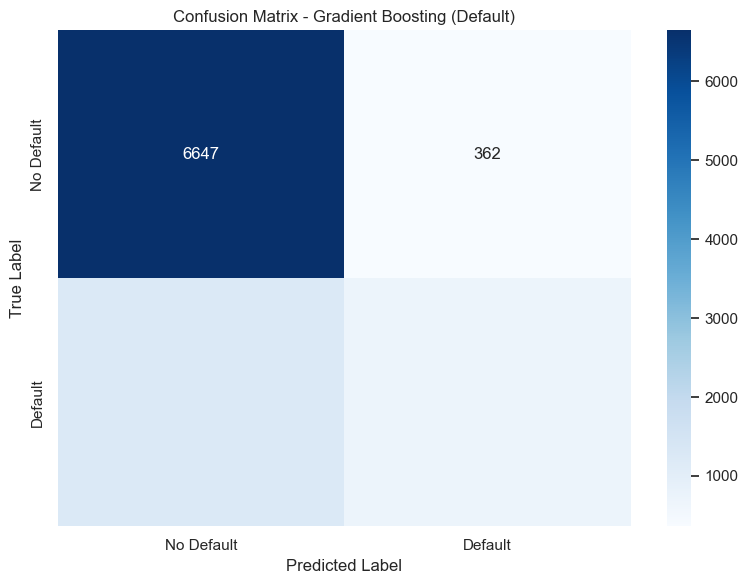


==== Gradient Boosting with Optimised Threshold ====
Best threshold: 0.100 (F2: 0.6406)
Metrics with optimised threshold (0.100):
Recall: 0.9166 (vs. 0.3651 with default threshold)
Precision: 0.2906
F1 Score: 0.4413
F2 Score: 0.6406

Confusion Matrix:
True Negatives: 2554 | False Positives: 4455
False Negatives: 166 | True Positives: 1825
Weighted Cost: 5285 (FN weighted 5x more than FP)


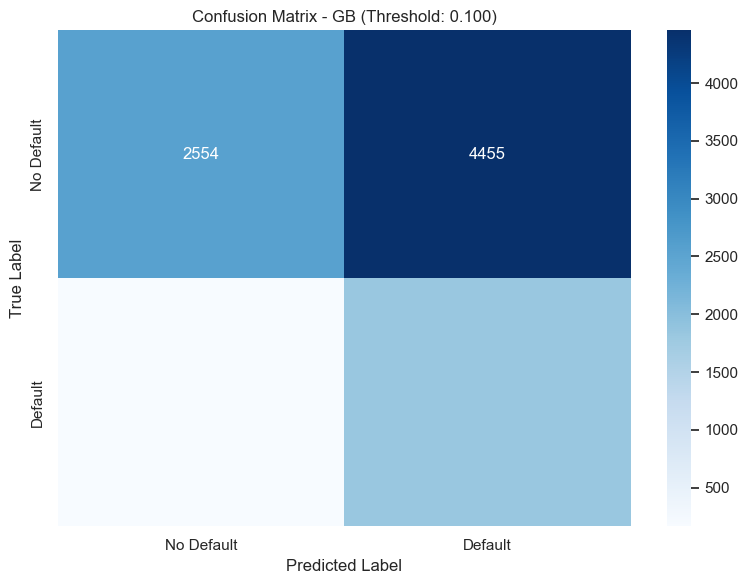

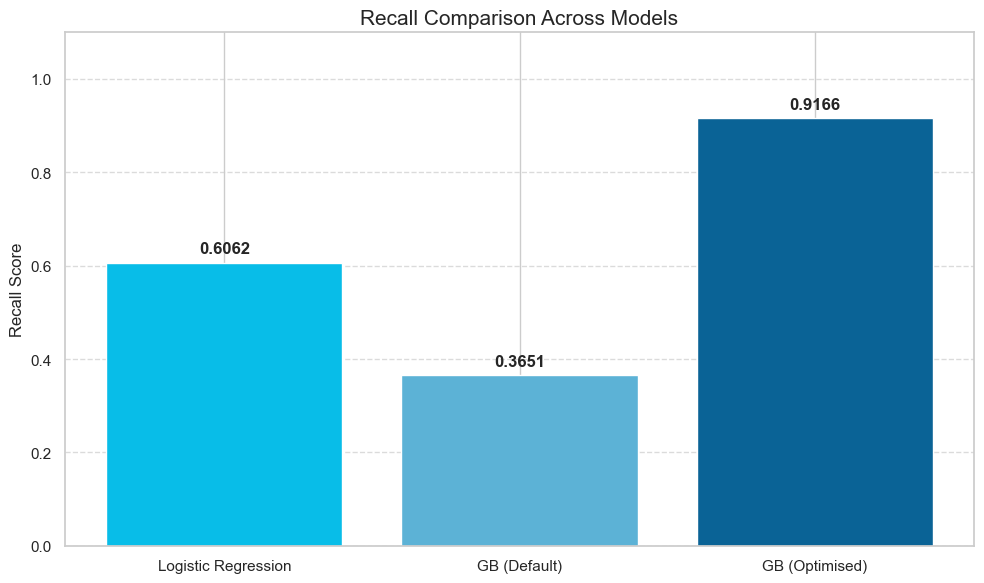


==== Model Building Complete ====
Best model: GB with optimised threshold (0.100)


In [307]:
# 4.1 Basic Gradient Boosting Model
print("\n==== Gradient Boosting Model ====")

# Create a pipeline with preprocessing and gradient boosting
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Train the basic gradient boosting model
gb_pipeline.fit(X_train, y_train)

# Evaluate the model
gb_metrics = evaluate_model(gb_pipeline, X_test, y_test, "Gradient Boosting (Default)")

# 4.2 Optimised Threshold for Gradient Boosting
print("\n==== Gradient Boosting with Optimised Threshold ====")

# Get predicted probabilities
y_pred_proba = gb_pipeline.predict_proba(X_test)[:, 1]

# Find the best threshold based on F2 score (which prioritizes recall)
thresholds = np.linspace(0.1, 0.5, 9)  # Try thresholds between 0.1 and 0.5
best_threshold = 0
best_f2 = 0

for threshold in thresholds:
    y_pred_th = (y_pred_proba >= threshold).astype(int)
    f2 = fbeta_score(y_test, y_pred_th, beta=2)
    
    if f2 > best_f2:
        best_f2 = f2
        best_threshold = threshold

print(f"Best threshold: {best_threshold:.3f} (F2: {best_f2:.4f})")

# Apply the best threshold
y_pred_best_th = (y_pred_proba >= best_threshold).astype(int)

# Calculate metrics with the optimised threshold
recall_opt = recall_score(y_test, y_pred_best_th)
precision_opt = precision_score(y_test, y_pred_best_th)
f1_opt = f1_score(y_test, y_pred_best_th)
cm_opt = confusion_matrix(y_test, y_pred_best_th)
tn, fp, fn, tp = cm_opt.ravel()
cost_opt = fp + (fn * 5)  # Same cost function as before

print(f"Metrics with optimised threshold ({best_threshold:.3f}):")
print(f"Recall: {recall_opt:.4f} (vs. {gb_metrics['recall']:.4f} with default threshold)")
print(f"Precision: {precision_opt:.4f}")
print(f"F1 Score: {f1_opt:.4f}")
print(f"F2 Score: {best_f2:.4f}")

print(f"\nConfusion Matrix:")
print(f"True Negatives: {tn} | False Positives: {fp}")
print(f"False Negatives: {fn} | True Positives: {tp}")
print(f"Weighted Cost: {cost_opt} (FN weighted 5x more than FP)")

# Plot confusion matrix with optimised threshold
plt.figure(figsize=(8, 6))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title(f'Confusion Matrix - GB (Threshold: {best_threshold:.3f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot6.png")
plt.show()

# 4.3 Compare Models
plt.figure(figsize=(10, 6))
models = ['Logistic Regression', 'GB (Default)', 'GB (Optimised)']
recalls = [logreg_metrics['recall'], gb_metrics['recall'], recall_opt]
colors = ['#08bde8', '#5cb2d6', '#0a6396']

plt.bar(models, recalls, color=colors)
plt.title('Recall Comparison Across Models', fontsize=15)
plt.ylabel('Recall Score', fontsize=12)
plt.ylim(0, max(recalls) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, recall in enumerate(recalls):
    plt.text(i, recall + 0.02, f"{recall:.4f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig("C:\\Users\\sofia\\Downloads\\holcim_assessment\\plot7.png")

plt.show()

print("\n==== Model Building Complete ====")
print(f"Best model: GB with optimised threshold ({best_threshold:.3f})")
